# <center>Part 1</center>

**The code below up to 1.2 is taken from the TP and needs to be modified.**

# Import

In [1]:
import numpy as np                     # Numerical algorithms on arrays
import cv2                             # OpenCV
from matplotlib import pyplot as plt   # Plot library
import matplotlib.cm as cm             # Image color map 
import edge_detector as ed             # A edge detector

##   1.1. Loading and displaying OpenCV images

In [5]:
# Load a grayscale image
building = cv2.imread('image_database/Building.png')

# Load a color imageBuilding
building_color = cv2.imread('image_database/Building.png', cv2.IMREAD_COLOR)

# Load a color image in grayscale format
road_gray = cv2.imread('image_database/Road.png', cv2.IMREAD_GRAYSCALE)

# Load a color image in grayscale format
road = cv2.imread('image_database/Road.png')

The format used by OpenCV is the folowing : 

<code>(height, width, channels (if several))</code>

stored in a numpy ndarray with unsigned integers from 0 to 255.

In [6]:
print("Object type in which the image is stored: ", type(building_color))
print("Shape of the array with a color image: ", building_color.shape)
print("Shape of the array with a gray image: ", road_gray.shape)
print("Data type is : ", building_color.dtype)

Object type in which the image is stored:  <class 'numpy.ndarray'>
Shape of the array with a color image:  (960, 1280, 3)
Shape of the array with a gray image:  (960, 1280)
Data type is :  uint8


Now that the images are stored in numpy arrays, we can display them using a built-in function of OpenCV.

To keep the image on screen, you need to use the keyboard binding function cv2.waitKey(int). Its argument is the time in milliseconds. The function waits for specified milliseconds for any keyboard event. If you press any key in that time, the program continues. If 0 is passed, it waits indefinitely for a key stroke.

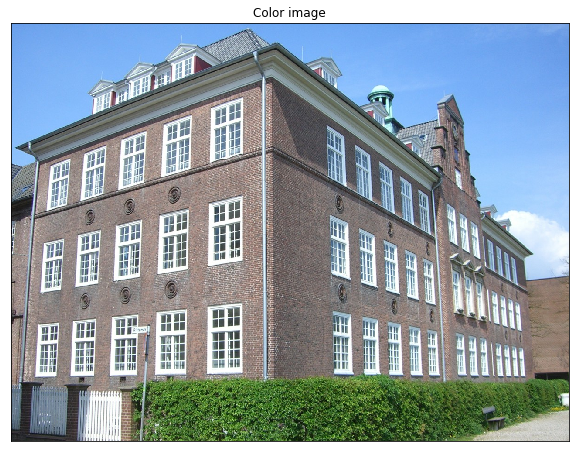

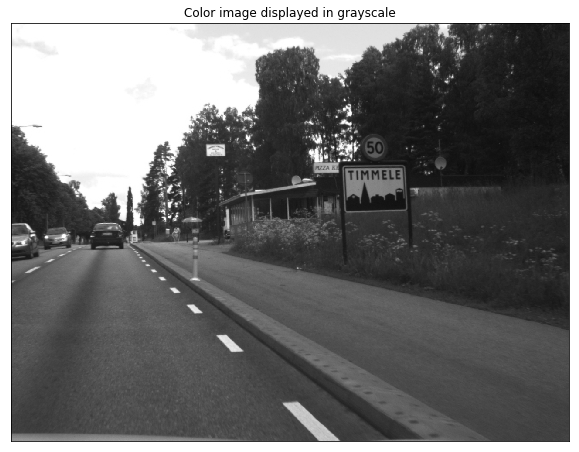

In [23]:
def display(title, img):
    """ 
    Display the image given.
    
    @Args:
        title:    [str] title to display
        img:      [np array] Image to display which can be in BGR ([? x ? x 3]) or gray ([? x ?])
    """
    if img.shape[-1]==3: # BGR to RGB
        b,g,r = cv2.split(img)
        imgRgb = cv2.merge( [r,g,b])
    else: # Gray to RGB
        imgRgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # Display using pyplot instead of cv2 because it might cause the jupyter notebook to crash.
    plt.figure(figsize = (10,10))
    fig = plt.imshow(imgRgb)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.title(title)
    plt.show()

# Display the image
display('Color image', building_color)
display('Color image displayed in grayscale', road_gray)

## 1.2. Edge points extraction

### 1.2.1 Morphological Gradient of Beucher

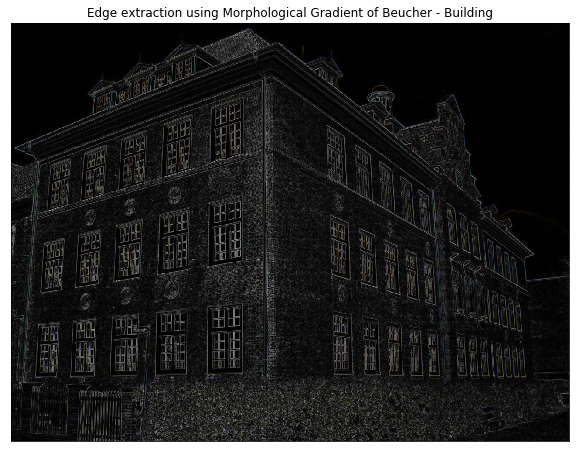

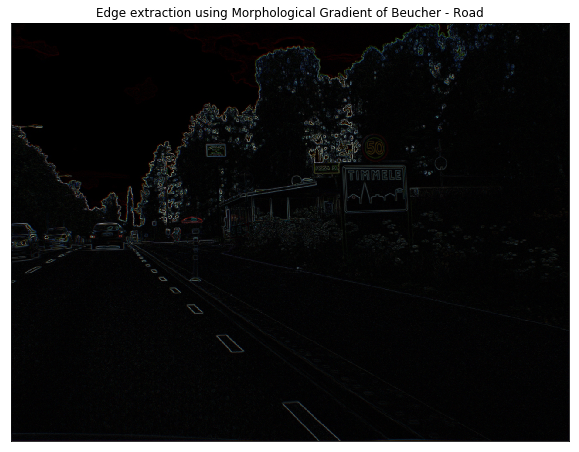

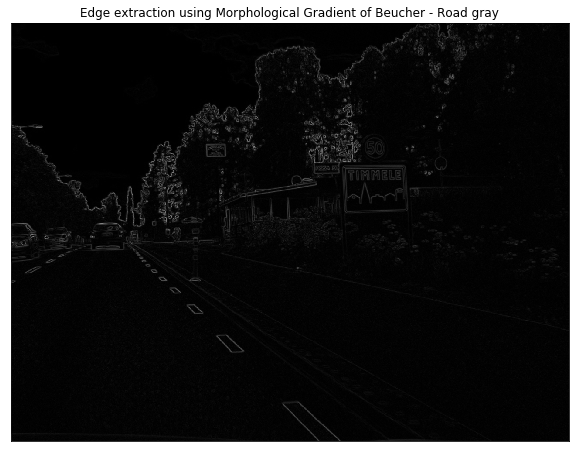

In [22]:
imgsToDetect = [building, road, road_gray]
imgsName = ["Building", "Road", "Road gray"]

for i in range(len(imgsToDetect)):
    imgEdges = ed.gradientOfBeucher(imgsToDetect[i], 2, 2)

    display('Edge extraction using Morphological Gradient of Beucher - '+imgsName[i], imgEdges)